In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV file
csv_file_path = 'dataset/deepneo/newneo_trainset.csv'
data = pd.read_csv(csv_file_path)

# Train-validation split (80% train, 20% validation)
train_data, val_data = train_test_split(data, test_size=0.7, random_state=42)

# Step 2: Load HLA embeddings from pickle file
with open('HLAseq_embeddings.pkl', 'rb') as f:
    hla_embeddings_raw = pickle.load(f)

# HLA 임베딩의 평균 계산
hla_embeddings = {}
for hla_name, embedding in hla_embeddings_raw.items():
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32)
    middle_embedding_tensor = embedding_tensor[1:-1]

# 가운데 벡터들에 대해 평균 계산
    hla_embeddings[hla_name] = torch.mean(middle_embedding_tensor, dim=0)

print("HLA embeddings loaded and averaged.")


HLA embeddings loaded and averaged.


In [13]:
# BLOSUM62 Matrix
# BLOSUM62 Matrix
blosum62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, -2, -1, -1, -1, -4],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, -1, -2, 0, -1, -4],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 4, -3, 0, -1, -4],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, -3, 1, -1, -4],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -1, -3, -1, -4],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2, 0, -2, 4, -1, -4],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 1, -3, 4, -1, -4],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -4, -2, -1, -4],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, -3, 0, -1, -4],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, -3, 3, -3, -1, -4],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, -4, 3, -3, -1, -4],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0, -3, 1, -1, -4],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, -3, 2, -1, -1, -4],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, -3, 0, -3, -1, -4],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, -2, -3, -1, -1, -4],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2, 0, -2, 0, -1, -4],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0, -1, -1, -1, -1, -4],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -2, -2, -1, -4],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -1, -2, -1, -4],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4, -3, 2, -2, -1, -4],
    'B': [-2, -1, 4, 4, -3, 0, 1, -1, 0, -3, -4, 0, -3, -3, -2, 0, -1, -4, -3, -3, 4, -3, 0, -1, -4],
        'J': [-2, -3, -3, -1, -2, -3, -4, -3, 3, 3, -3, 2, 0, -3, -2, -1, -2, -1, 2, -3, 3, -3, -1, -4],
    'Z': [-1, 0, 0, 1, -3, 4, 4, -2, 0, -3, -3, 1, -1, -3, -1, 0, -1, -2, -2, -2, 0, -3, 4, -1, -4],
    'X': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -4],
    '*': [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 1]
}

# Step 3: Encode Epitope using BLOSUM62 matrix
def blosum62_encode(epitope, blosum62):
    encoded = [blosum62[aa] for aa in epitope]
    return torch.tensor(encoded, dtype=torch.float32)

# Step 4: Create a custom dataset
class EpitopeDataset(Dataset):
    def __init__(self, data, hla_embeddings, blosum62):
        self.data = data
        self.hla_embeddings = hla_embeddings
        self.blosum62 = blosum62

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        hla_name = row['HLA_Name']
        epitope = row['Epi_Seq']
        binding = row['Target']
        
        hla_embedding = self.hla_embeddings[hla_name]
        epitope_encoded = blosum62_encode(epitope, self.blosum62)
        
        return torch.tensor(hla_embedding, dtype=torch.float32), epitope_encoded, torch.tensor(binding, dtype=torch.float32)

# Create train and validation datasets and dataloaders
train_dataset = EpitopeDataset(train_data, hla_embeddings, blosum62)
val_dataset = EpitopeDataset(val_data, hla_embeddings, blosum62)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

print("Dataset and DataLoader created.")

Dataset and DataLoader created.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomTransformer(nn.Module):
    def __init__(self, input_dim, d_model=1536, nhead=8, num_layers=10, dropout_rate=0.2):
        super(CustomTransformer, self).__init__()
        
        # Self-Attention layer for epitope_encoded
        self.self_attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=5,  dropout=dropout_rate)
        
        # Fully connected layer for epitope encoding to match d_model (for Query)
        self.fc_query = nn.Linear(input_dim, d_model)
        
        # Separate fully connected layers for HLA embedding to match d_model (for Key and Value)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        
        # MultiheadAttention layers
        self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout_rate)
        self.self_attention_2 = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout_rate)
        self.self_attention_3 = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout_rate)
        
        # Layer normalization and dropout after each self-attention layer
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.layer_norm_3 = nn.LayerNorm(d_model)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Output layer for final prediction
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, hla_embedding, epitope_encoded):
        # Self-Attention on epitope_encoded
        epitope_encoded = epitope_encoded.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)
        attn_output, _ = self.self_attention(epitope_encoded, epitope_encoded, epitope_encoded)
        attn_output = attn_output.permute(1, 0, 2)  # (batch_size, seq_len, input_dim)
        
        # Mean pooling over sequence dimension to remove seq_len
        query = attn_output.mean(dim=1)  # (batch_size, d_model)
        query = self.fc_query(query)  # (batch_size, d_model)
        
        # Transform HLA embedding to key and value using separate FC layers
        key = self.fc_key(hla_embedding)  # (batch_size, d_model)
        value = self.fc_value(hla_embedding)  # (batch_size, d_model)
        
        # Reshape query, key, value for MultiheadAttention (1, batch_size, d_model)
        query = query.unsqueeze(0)  # (1, batch_size, d_model)
        key = key.unsqueeze(0)  # (1, batch_size, d_model)
        value = value.unsqueeze(0)  # (1, batch_size, d_model)
        
        # Apply MultiheadAttention
        attn_output, _ = self.multihead_attn(query, key, value)  # (1, batch_size, d_model)
        
        # Apply first additional self-attention layer
        attn_output, _ = self.self_attention_2(attn_output, attn_output, attn_output)  # (1, batch_size, d_model)
        attn_output = self.layer_norm_1(attn_output)
        
        # Apply second additional self-attention layer
        attn_output, _ = self.self_attention_3(attn_output, attn_output, attn_output)  # (1, batch_size, d_model)
        attn_output = self.layer_norm_2(attn_output)

        # Squeeze to remove the seq_len dimension
        attn_output = attn_output.squeeze(0)  # (batch_size, d_model)
        
        # Apply dropout
        attn_output = self.dropout(attn_output)
        
        # Final output layer
        output = self.output_layer(attn_output)  # (batch_size, 1)
        
        return output

# Initialize model, loss function, and optimizer
transformer_with_linear_model = CustomTransformer(input_dim=25)  # input_dim은 epitope의 인코딩 크기
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = torch.optim.Adam(transformer_with_linear_model.parameters(), lr=0.001)


In [18]:
import os

# Step 6: Training loop with validation
num_epochs = 500
patience = 10  # Early stopping patience
stopping_threshold = 1e-4  # Improvement threshold for early stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델을 GPU로 이동
transformer_with_linear_model.to(device)

# 최적 손실 값을 추적하기 위한 변수 초기화
best_loss = float('inf')
best_model_path = "model/best_model.pth"
no_improvement_count = 0  # 개선이 없는 에폭 수를 추적

# 모델을 저장할 폴더 생성 (존재하지 않으면)
if not os.path.exists('model'):
    os.makedirs('model')

# Training loop with validation
print("Starting training...")
for epoch in range(num_epochs):
    transformer_with_linear_model.train()
    epoch_train_loss = 0.0
    for hla_embedding, epitope_encoded, target in train_dataloader:
        # 데이터와 타겟을 GPU로 이동
        hla_embedding = hla_embedding.to(device)
        epitope_encoded = epitope_encoded.to(device)
        target = target.to(device)

        # Forward pass
        output = transformer_with_linear_model(hla_embedding, epitope_encoded)

        # Output 크기를 타겟 크기와 맞추기 위해 squeeze 적용
        output = output.squeeze(dim=-1)  # (batch_size, 1) -> (batch_size,)

        # Calculate loss
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()


        optimizer.step()

        epoch_train_loss += loss.item()

    # 에폭당 평균 학습 손실 계산
    epoch_train_loss /= len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')

    # Validation step
    transformer_with_linear_model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for hla_embedding, epitope_encoded, target in val_dataloader:
            # 데이터와 타겟을 GPU로 이동
            hla_embedding = hla_embedding.to(device)
            epitope_encoded = epitope_encoded.to(device)
            target = target.to(device)

            # Forward pass
            output = transformer_with_linear_model(hla_embedding, epitope_encoded)

            # Output 크기를 타겟 크기와 맞추기 위해 squeeze 적용
            output = output.squeeze(dim=-1)  # (batch_size, 1) -> (batch_size,)

            # Calculate loss
            loss = criterion(output, target)

            epoch_val_loss += loss.item()

    # 에폭당 평균 검증 손실 계산
    epoch_val_loss /= len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

    # 최적 모델 저장 (검증 손실이 가장 낮은 경우)
    if epoch_val_loss < best_loss - stopping_threshold:
        best_loss = epoch_val_loss
        torch.save(transformer_with_linear_model.state_dict(), best_model_path)
        print(f"Best model updated and saved at {best_model_path}")
        no_improvement_count = 0  # 개선이 있을 때는 카운터를 초기화
    else:
        no_improvement_count += 1  # 개선이 없으면 카운터 증가
        print(f"No improvement in validation loss for {no_improvement_count} epochs.")

    # Early Stopping 조건 확인
    if no_improvement_count >= patience:
        print(f"Stopping early due to no improvement in validation loss for {patience} epochs.")
        break

print("Training completed.")


Using device: cuda
Starting training...


/tmp/ipykernel_65453/627645507.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(hla_embedding, dtype=torch.float32), epitope_encoded, torch.tensor(binding, dtype=torch.float32)


Epoch [1/500], Train Loss: 1.6198
Epoch [1/500], Validation Loss: 0.5866
Best model updated and saved at model/best_model.pth
Epoch [2/500], Train Loss: 0.5865
Epoch [2/500], Validation Loss: 0.5837
Best model updated and saved at model/best_model.pth
Epoch [3/500], Train Loss: 0.5857
Epoch [3/500], Validation Loss: 0.5825
Best model updated and saved at model/best_model.pth
Epoch [4/500], Train Loss: 0.5854
Epoch [4/500], Validation Loss: 0.5823
Best model updated and saved at model/best_model.pth
Epoch [5/500], Train Loss: 0.5845
Epoch [5/500], Validation Loss: 0.5803
Best model updated and saved at model/best_model.pth
Epoch [6/500], Train Loss: 0.5822
Epoch [6/500], Validation Loss: 0.5790
Best model updated and saved at model/best_model.pth
Epoch [7/500], Train Loss: 0.5778
Epoch [7/500], Validation Loss: 0.5678
Best model updated and saved at model/best_model.pth
Epoch [8/500], Train Loss: 0.5643
Epoch [8/500], Validation Loss: 0.5466
Best model updated and saved at model/best_mo

HLA embeddings loaded and averaged.


/tmp/ipykernel_65453/1963438426.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self_attention_model.load_state_dict(torch.load("model/best_model.pth"))
/tmp/ipykernel_

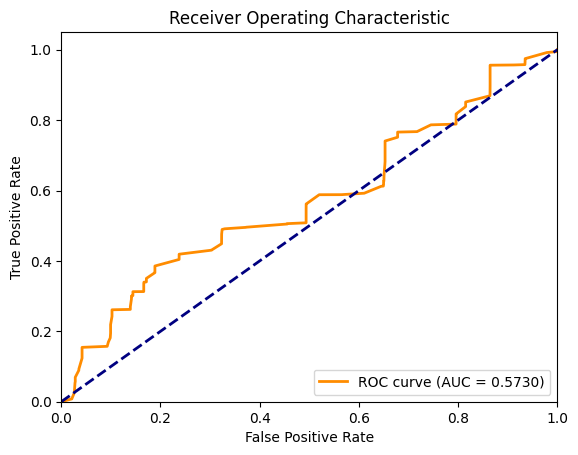

AUC: 0.5730


In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Load the CSV file for the test set
csv_test_file_path = 'dataset/deepneo/newneo_testset.csv'
test_data = pd.read_csv(csv_test_file_path)

# Step 2: Load HLA embeddings from pickle file
with open('HLAseq_embeddings.pkl', 'rb') as f:
    hla_embeddings_raw = pickle.load(f)

# HLA 임베딩의 평균 계산
hla_embeddings = {}
for hla_name, embedding in hla_embeddings_raw.items():
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32)
    hla_embeddings[hla_name] = torch.mean(embedding_tensor, dim=0)

print("HLA embeddings loaded and averaged.")

# BLOSUM62 Matrix
blosum62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, -2, -1, -1, -1, -4],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, -1, -2, 0, -1, -4],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 4, -3, 0, -1, -4],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, -3, 1, -1, -4],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -1, -3, -1, -4],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2, 0, -2, 4, -1, -4],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 1, -3, 4, -1, -4],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -4, -2, -1, -4],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, -3, 0, -1, -4],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, -3, 3, -3, -1, -4],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, -4, 3, -3, -1, -4],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0, -3, 1, -1, -4],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, -3, 2, -1, -1, -4],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, -3, 0, -3, -1, -4],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, -2, -3, -1, -1, -4],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2, 0, -2, 0, -1, -4],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0, -1, -1, -1, -1, -4],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -2, -2, -1, -4],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -1, -2, -1, -4],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4, -3, 2, -2, -1, -4],
    'B': [-2, -1, 4, 4, -3, 0, 1, -1, 0, -3, -4, 0, -3, -3, -2, 0, -1, -4, -3, -3, 4, -3, 0, -1, -4],
    'J': [-2, -3, -3, -1, -2, -3, -4, -3, 3, 3, -3, 2, 0, -3, -2, -1, -2, -1, 2, -3, 3, -3, -1, -4],
    'Z': [-1, 0, 0, 1, -3, 4, 4, -2, 0, -3, -3, 1, -1, -3, -1, 0, -1, -2, -2, -2, 0, -3, 4, -1, -4],
    'X': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -4],
    '*': [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 1]
}

# Step 3: Encode Epitope using BLOSUM62 matrix
def blosum62_encode(epitope, blosum62):
    encoded = [blosum62[aa] for aa in epitope]
    return torch.tensor(encoded, dtype=torch.float32)

# Step 4: Create a custom dataset for the test set
class EpitopeDataset(Dataset):
    def __init__(self, data, hla_embeddings, blosum62):
        self.data = data
        self.hla_embeddings = hla_embeddings
        self.blosum62 = blosum62

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        hla_name = row['HLA_Name']
        epitope = row['Epi_Seq']
        binding = row['Target']

        # 결측치 처리
        if pd.isna(hla_name) or hla_name not in self.hla_embeddings:
            raise ValueError(f"HLA name {hla_name} is not valid or is missing in the embeddings.")
        
        hla_embedding = self.hla_embeddings[hla_name]
        epitope_encoded = blosum62_encode(epitope, self.blosum62)
        
        return torch.tensor(hla_embedding, dtype=torch.float32), epitope_encoded, torch.tensor(binding, dtype=torch.float32)

# Test 데이터셋 로드 후 결측치 제거
test_data.dropna(subset=['HLA_Name', 'Epi_Seq'], inplace=True)

# Create the test dataset and dataloader
test_dataset = EpitopeDataset(test_data, hla_embeddings, blosum62)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Step 5: Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
self_attention_model = CustomTransformer(input_dim=25)
self_attention_model.load_state_dict(torch.load("model/best_model.pth"))
self_attention_model.to(device)
self_attention_model.eval()

# Step 6: Make predictions on the test set
all_targets = []
all_predictions = []

with torch.no_grad():
    for hla_embedding, epitope_encoded, target in test_dataloader:
        hla_embedding = hla_embedding.to(device)
        epitope_encoded = epitope_encoded.to(device)
        target = target.to(device)
        
        output = self_attention_model(hla_embedding, epitope_encoded)  # 모델 출력 바로 사용
        predictions = torch.sigmoid(output.squeeze(dim=-1))  # Squeeze 적용 후 sigmoid
        
        all_targets.extend(target.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Step 7: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_targets, all_predictions)
roc_auc = auc(fpr, tpr)

# Step 8: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.4f}')
